In [1]:
import localgraphclustering as lgc
import numpy as np

import matplotlib.pyplot as plt

import sys
import os
sys.path.insert(0, os.path.join("..", "LocalGraphClustering", "notebooks"))
import helper
from functools import partial


In [24]:
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from bisect import bisect_left as bl
import numpy as np
from collections import defaultdict
from scipy.sparse.csgraph import csgraph_from_dense
from scipy.sparse.csgraph import connected_components

def persona_graph_fast(M):
    # M must be symmetric csc_matrix or csr_matrix with indices sorted
    assert((isinstance(M,csr_matrix) | isinstance(M,csc_matrix)) & M.has_sorted_indices)
    assert((M != M.T).sum() == 0)
    bi_rows = [] # store row labels of the biedge graph
    bi_cols = [] # store col labels of the biedge graph
    data = []
    N = M.nnz
    biedges = np.zeros((N,2),dtype=np.int32) # map node index in the biedge graph 
                                             # to the actual edge in the original graph
    for i in range(M.shape[0]):
        # this loop and the next loop iterate through all pairs of edges connected to node i
        for u in range(M.indptr[i],M.indptr[i+1]):
            biedges[u][0] = i
            biedges[u][1] = M.indices[u]
            a = M.indices[M.indptr[M.indices[u]]:M.indptr[M.indices[u]+1]] # find neighbors of node M.indices[u]
            if len(a) == 0:
                continue
            for v in range(u+1,M.indptr[i+1]):
                biedges[v][0] = i
                biedges[v][1] = M.indices[v]
                # use binary search to check if these two edges form a triangle
                idx = bl(a,M.indices[v])
                if idx < len(a) and a[idx] == M.indices[v]:
                    bi_rows.append(u)
                    bi_cols.append(v)
                    data.append(1)
    # store the biedge graph in csr format
    csr = csr_matrix((data,(bi_rows,bi_cols)),shape=(N,N))
    # find all connected components of the biedge graph
    nc_all,cc_all = connected_components(csr)
    ccs_all = [[] for _ in range(nc_all)] # assign nodes to components
    # reshape cc_all to build a array to store all indices for each component
    for idx,k in enumerate(cc_all):
        ccs_all[k].append(idx)
    personas = [[] for i in range(M.shape[0])] # find connected components for each node in the original graph
    for i in range(nc_all):
        # this is a connected component for node "parent" in the original graph
        parent = biedges[ccs_all[i][0]][0]
        for v in ccs_all[i]:
            # each node in a component in the biedge graph should have the same parent when mapping back to the original edge
            assert(biedges[v][0] == parent)
        personas[parent].append([biedges[v][1] for v in ccs_all[i]])
    # now we have computed connected components for each node subgraph in the original graph
    # next step is to add personas for each node
    new_ids = {}
    old_ids = {}
    cc_mapping = defaultdict(dict)
    ind = 0
    new_edges = []
    for i in range(M.shape[0]):
        nc,ccs = len(personas[i]),personas[i]
        ccs_filtered = []
        to_keep = 0
        for j in range(nc):
            cc = np.array(ccs[j])
            # filter out self loops
            index = np.argwhere(cc==i)
            cc = np.delete(cc, index)
            if len(cc) > 0:
                to_keep += 1
                ccs_filtered.append(cc)
        nc = to_keep 
        ccs = ccs_filtered
        if nc == 0:
            old_ids[ind] = i
            ind += 1
        for j in range(nc): # for each component
            for k in ccs[j]: # for each node in that component
                new_edges.append((ind,k))
                cc_mapping[i][k] = j # record which component of node i node k comes from
            old_ids[ind] = i
            new_ids[(i,j)] = ind 
            ind += 1
    new_edges = [(e[0],new_ids[(e[1],cc_mapping[e[1]][old_ids[e[0]]])]) for e in new_edges]
    return new_edges, old_ids

def test_persona_graph_fast():
    # test case from the paper
    M = [('a','b'),('a','c'),('a','e'),('a','h'),('a','g'),('a','i'),('f','i'),('f','g'),('f','h'),('f','e'),('f','b'),('f','c'),('g','i'),('g','h'),('b','e'),('b','c'),('j','i'),('j','h'),('d','e'),('d','c'),('k','j'),('k','d'),('i','h'),('j','d'),('e','c')]
    G = np.zeros((11,11))
    for e in M:
        G[ord(e[0])-ord('a'),ord(e[1])-ord('a')] = 1
    G = G+G.T
    G = csgraph_from_dense(G)
    new_edges, old_ids = persona_graph_fast(G)
    new_G = csr_matrix((np.ones(len(new_edges)),([i[0] for i in new_edges],[i[1] for i in new_edges])))
    truth = [(0, 2),(0, 3),(0, 6),(1, 9),(1, 10),(1, 11),(2, 0),(2, 3),(2, 6),(2, 7),
             (3, 0),(3, 2),(3, 4),(3, 6),(3, 7),(4, 3),(4, 6),(5, 12),(5, 14),(6, 0),
             (6, 2),(6, 3),(6, 4),(6, 7),(7, 2),(7, 3),(7, 6),(8, 9),(8, 10),(8, 11),
             (9, 1),(9, 8),(9, 10),(9, 11),(10, 1),(10, 8),(10, 9),(10, 11),(10, 13),(11, 1),
             (11, 8),(11, 9),(11, 10),(11, 13),(12, 5),(12, 14),(13, 10),(13, 11),(14, 5),(14, 12)]
    truth = csr_matrix((np.ones(len(truth)),([i[0] for i in truth],[i[1] for i in truth])))
    assert((new_G != truth).sum() == 0)

    # simple 4 node clique
    M = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
    G = np.zeros((4,4))
    for e in M:
        G[e[0],e[1]] = 1
    G = G+G.T
    G = csgraph_from_dense(G)
    new_edges, old_ids = persona_graph_fast(G)
    new_G = csr_matrix((np.ones(len(new_edges)),([i[0] for i in new_edges],[i[1] for i in new_edges])))
    assert((new_G != G).sum() == 0)

    # a star like graph with two pairs of separated neighbors connected
    M = [(0,1),(0,2),(0,3),(0,4),(1,2),(3,4)]
    G = np.zeros((5,5))
    for e in M:
        G[e[0],e[1]] = 1
    G = G+G.T
    G = csgraph_from_dense(G)
    new_edges, old_ids = persona_graph_fast(G)
    new_G = csr_matrix((np.ones(len(new_edges)),([i[0] for i in new_edges],[i[1] for i in new_edges])))
    truth = [(0,2),(0,3),(1,4),(1,5),(2,3),(4,5)]
    truth = csr_matrix((np.ones(len(truth)),([i[0] for i in truth],[i[1] for i in truth])),(6,6))
    truth = truth + truth.T
    assert((new_G != truth).sum() == 0)

test_persona_graph_fast() 

def persona_graph(g):
    newedges, ids = persona_graph_fast(g.adjacency_matrix)
    source,target = ([ a for a,b in newedges ], [ b for a,b in newedges ])
    weight = np.ones(len(source))
    p = lgc.GraphLocal()
    p.list_to_gl(source,target,weight)
    return p

In [18]:
g = helper.lgc_data("JohnsHopkins")
g._num_vertices

5180

In [15]:
for gname in helper.lgc_graphlist:
    print(gname)
    g = helper.lgc_data(gname)
    g.discard_weights()
    p = persona_graph(g)
    pcc = p.largest_component()
    

senate
There are  1  connected components in the graph
Erdos02
There are  5612  connected components in the graph
JohnsHopkins


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (5612) components, using the largest with 1007 / 12246 nodes



There are  2222  connected components in the graph
Colgate88


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (2222) components, using the largest with 5169 / 9618 nodes

/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



There are  716  connected components in the graph
usroads


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (716) components, using the largest with 3528 / 4962 nodes



There are  153726  connected components in the graph
ppi_mips


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (153726) components, using the largest with 6 / 311563 nodes



There are  166  connected components in the graph
ASTRAL


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (166) components, using the largest with 97 / 1262 nodes



There are  6  connected components in the graph
sfld


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (6) components, using the largest with 1048 / 1058 nodes



There are  1  connected components in the graph
find_V
There are  1  connected components in the graph
ppi-homo
There are  14483  connected components in the graph
neuro-fmri-01


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (14483) components, using the largest with 3836 / 33465 nodes



There are  979  connected components in the graph
ca-GrQc


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (979) components, using the largest with 5580 / 6876 nodes



There are  1930  connected components in the graph
dolphins
There are  42  connected components in the graph
disconnected
There are  6  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (1930) components, using the largest with 1018 / 6880 nodes

/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (42) components, using the largest with 27 / 130 nodes

/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (6) components, using the largest with 3 / 13 nodes



senate
There are  1  connected components in the graph
There are  1  connected components in the graph
approxPageRank:ncpapr_acl:    0.4 neighborhoods
approxPageRank:ncpapr_acl:   15.0 localmin rho=1.0e-05
approxPageRank:ncpapr_acl:   17.8 localmin rho=1.0e-04
approxPageRank:ncpapr_acl:  168.3 random_node rho=1.0e-05
approxPageRank:ncpapr_acl:  189.4 random_node rho=1.0e-04
approxPageRank:ncpapr_acl:  340.1 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_acl:  422.0 random_neighborhood rho=1.0e-04


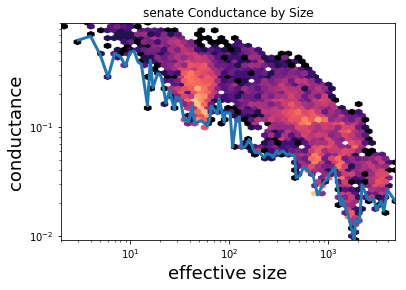

Erdos02
There are  5612  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (5612) components, using the largest with 1007 / 12246 nodes



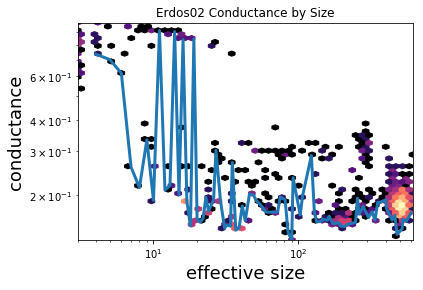

JohnsHopkins
There are  2222  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (2222) components, using the largest with 5169 / 9618 nodes



approxPageRank:ncpapr_acl:    0.6 neighborhoods
approxPageRank:ncpapr_acl:    4.3 localmin rho=1.0e-05
approxPageRank:ncpapr_acl:    6.5 localmin rho=1.0e-04
approxPageRank:ncpapr_acl:   38.8 random_node rho=1.0e-05
approxPageRank:ncpapr_acl:   47.6 random_node rho=1.0e-04
approxPageRank:ncpapr_acl:  199.4 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_acl:  229.6 random_neighborhood rho=1.0e-04


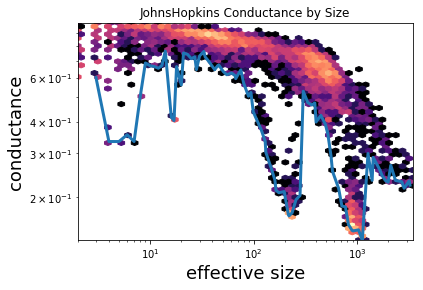

Colgate88


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



There are  716  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (716) components, using the largest with 3528 / 4962 nodes



approxPageRank:ncpapr_acl:    0.5 neighborhoods
approxPageRank:ncpapr_acl:    4.0 localmin rho=1.0e-05
approxPageRank:ncpapr_acl:    6.4 localmin rho=1.0e-04
approxPageRank:ncpapr_acl:   30.6 random_node rho=1.0e-05
approxPageRank:ncpapr_acl:   36.6 random_node rho=1.0e-04
approxPageRank:ncpapr_acl:  188.8 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_acl:  218.3 random_neighborhood rho=1.0e-04


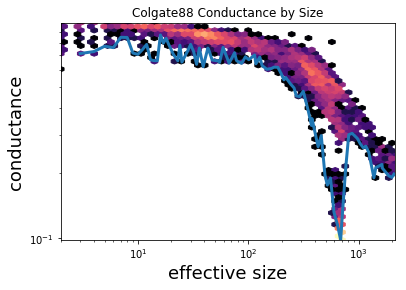

usroads
There are  153726  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (153726) components, using the largest with 6 / 311563 nodes

/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/ncp.py:253: UserWarning:

there are 2 localmin nodes and they were filtered away by mindegree=5



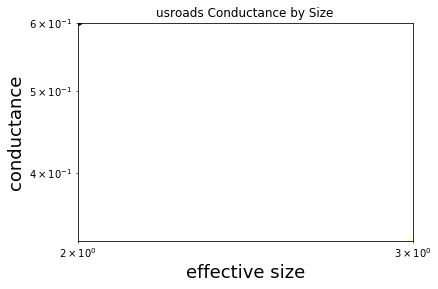

ppi_mips
There are  166  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (166) components, using the largest with 97 / 1262 nodes



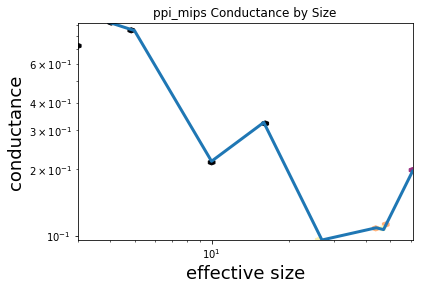

ASTRAL
There are  6  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (6) components, using the largest with 1048 / 1058 nodes



approxPageRank:ncpapr_acl:    1.0 neighborhoods
approxPageRank:ncpapr_acl:   10.4 localmin rho=1.0e-05
approxPageRank:ncpapr_acl:   13.6 localmin rho=1.0e-04
approxPageRank:ncpapr_acl:   16.9 random_node rho=1.0e-05
approxPageRank:ncpapr_acl:   18.7 random_node rho=1.0e-04
approxPageRank:ncpapr_acl:  173.7 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_acl:  311.8 random_neighborhood rho=1.0e-04


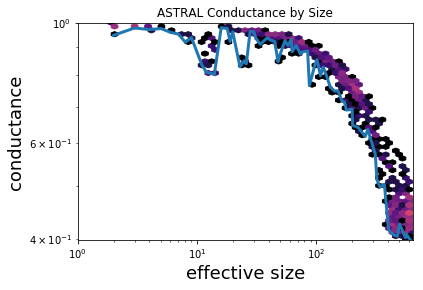

sfld
There are  1  connected components in the graph
There are  1  connected components in the graph


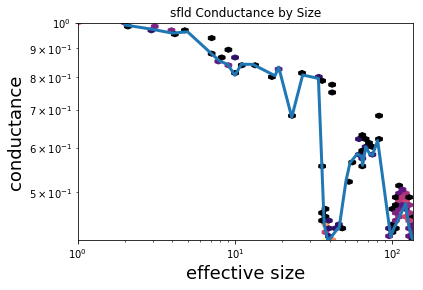

find_V
There are  1  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/ncp.py:247: UserWarning:

There are no localmin nodes



approxPageRank:ncpapr_acl:    0.5 neighborhoods
approxPageRank:ncpapr_acl:    1.9 localmin rho=1.0e-05
approxPageRank:ncpapr_acl:    2.1 localmin rho=1.0e-04
approxPageRank:ncpapr_acl:    3.8 random_node rho=1.0e-05
approxPageRank:ncpapr_acl:    4.7 random_node rho=1.0e-04
approxPageRank:ncpapr_acl:  157.9 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_acl:  231.7 random_neighborhood rho=1.0e-04


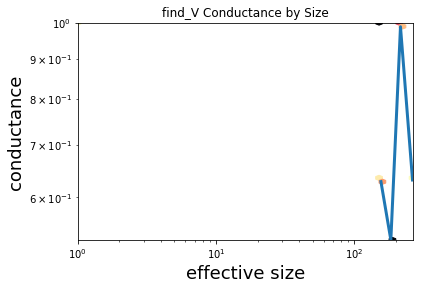

ppi-homo
There are  14483  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (14483) components, using the largest with 3836 / 33465 nodes



approxPageRank:ncpapr_acl:    0.2 neighborhoods
approxPageRank:ncpapr_acl:    4.3 localmin rho=1.0e-05
approxPageRank:ncpapr_acl:    5.4 localmin rho=1.0e-04
approxPageRank:ncpapr_acl:   94.2 random_node rho=1.0e-05
approxPageRank:ncpapr_acl:  104.7 random_node rho=1.0e-04
approxPageRank:ncpapr_acl:  172.3 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_acl:  185.5 random_neighborhood rho=1.0e-04


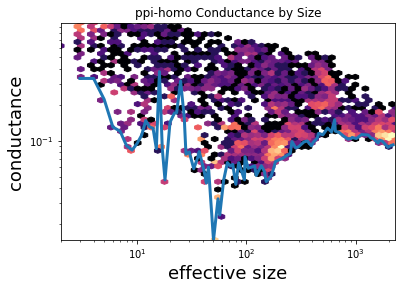

neuro-fmri-01
There are  979  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (979) components, using the largest with 5580 / 6876 nodes



approxPageRank:ncpapr_acl:    0.4 neighborhoods
approxPageRank:ncpapr_acl:    9.1 localmin rho=1.0e-05
approxPageRank:ncpapr_acl:   12.3 localmin rho=1.0e-04
approxPageRank:ncpapr_acl:  163.1 random_node rho=1.0e-05
approxPageRank:ncpapr_acl:  181.4 random_node rho=1.0e-04
approxPageRank:ncpapr_acl:  332.1 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_acl:  385.3 random_neighborhood rho=1.0e-04


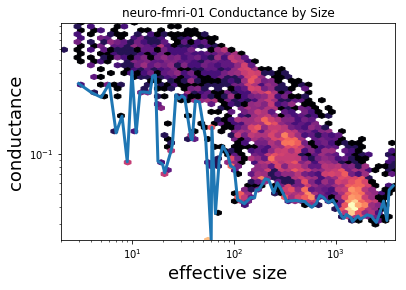

ca-GrQc
There are  1930  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (1930) components, using the largest with 1018 / 6880 nodes



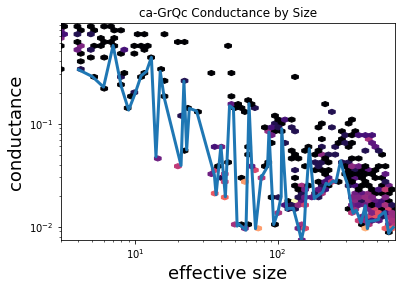

dolphins
There are  42  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (42) components, using the largest with 27 / 130 nodes



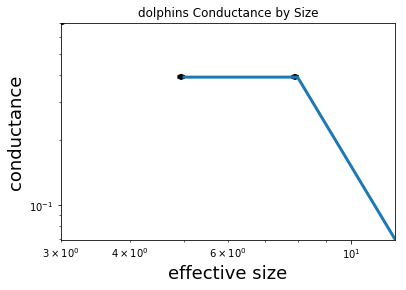

disconnected
There are  6  connected components in the graph
There are  1  connected components in the graph


/home/dgleich/.local/lib/python3.5/site-packages/localgraphclustering/GraphLocal.py:552: UserWarning:

The graph has multiple (6) components, using the largest with 3 / 13 nodes



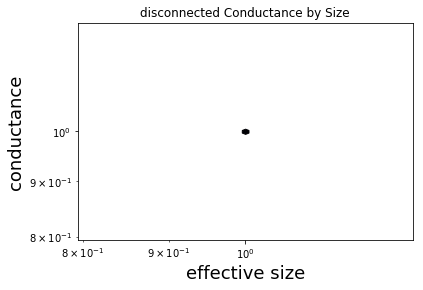

In [23]:
for gname in helper.lgc_graphlist:
    print(gname)
    g = helper.lgc_data(gname)
    g.discard_weights()
    p = persona_graph(g)
    pcc = p.largest_component()
    ncp = lgc.NCPData(pcc)
    ncp.approxPageRank()
    ncp.write("ncps/persona-apr-%s"%(gname))
    
    fig = lgc.NCPPlots(ncp).cond_by_size()[0]
    fig.axes[0].set_title(gname + " Conductance by Size")
    plt.show(fig)
    fig.savefig("figures/crd-ncp-"+gname+".pdf", bbox_inches="tight", figsize=(3,3))
    